In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter # Para formatear los ejes
import seaborn as sb

### Carga de datos

In [2]:
# Visualiza las 23 columnas
pd.set_option('display.max_columns', 23)
# Carga del CSV en un DataFrame df (usando como delimitador la coma ',')
df = pd.read_csv('train.csv')

Para los datos renombrados y reordenados se va a usar el DataFrame dfok.

In [3]:
# Se renombran las columnas
nombresNuevos = {
                 'id' : 'ID',
                 'titulo' : 'Titulo',
                 'descripcion' : 'Descripcion',
                 'tipodepropiedad' : 'TipoPropiedad',
                 'direccion' : 'Direccion',
                 'ciudad' : 'Ciudad',
                 'provincia' : 'Provincia',
                 'antiguedad' : 'Antiguedad',
                 'habitaciones' : 'CantHabitaciones',
                 'garages' : 'CantGarages',
                 'banos' : 'CantBanos',
                 'metroscubiertos' : 'MetrosCuadradosCubiertos',
                 'metrostotales' : 'MetrosCuadradosTotales',
                 'idzona' : 'IDZona',
                 'lat' : 'Latitud',
                 'lng' : 'Longitud',
                 'fecha' : 'Fecha',
                 'gimnasio' : 'TieneGimnasio',
                 'usosmultiples' : 'TieneUsosMultiples',
                 'piscina' : 'TienePileta',
                 'escuelascercanas' : 'TieneEscuelasCerca',
                 'centroscomercialescercanos' : 'TieneShoppingsCerca',
                 'precio' : 'Precio'
                
}
dfok = df.rename(columns = nombresNuevos)

In [4]:
# Se Reordenan las columnas
nombresEnOrden = [
                 'ID',
                 'Titulo',
                 'TipoPropiedad',
                 'Precio',
                 'Fecha',
                 'Antiguedad',
                 'MetrosCuadradosCubiertos',
                 'MetrosCuadradosTotales',
                 'Descripcion',
                 
                 'CantHabitaciones',
                 'CantGarages',
                 'CantBanos',
               
                 'IDZona',
                 'Direccion',
                 'Ciudad',
                 'Provincia',
                 'Latitud',
                 'Longitud',
                 
                 'TieneGimnasio',
                 'TieneUsosMultiples',
                 'TienePileta',
                 'TieneEscuelasCerca',
                 'TieneShoppingsCerca'
    ]                 
dfok = dfok[nombresEnOrden];

### Análisis de propiedades por sus comodidades

Se va a analizar la relación entre la provincia y la cantidad de tipos de comodidad de las propiedades.

In [5]:
columnas = ['Ciudad',
            'Provincia',
            'TieneGimnasio',
            'TieneUsosMultiples',
            'TienePileta',
            'TieneEscuelasCerca',
            'TieneShoppingsCerca',
            'Precio'] 
df_abool = dfok[columnas].copy()

En el análisis exploratorio de Navent se indica que los nombres de ciudades y provincias son String, el precio se representa con tipo entero y las demás columnas de comodidades son Booleanas. 

Se crea un nuevo DataFrame df_abool que copia columnas de interés del DataFrame original.

### Análisis de calidad de datos

In [6]:
print(df_abool.isnull().sum())
memoria_usada = df_abool.memory_usage()
print('\nTotal memoria usada sin cambios de tipos {:.2f}'.format(memoria_usada.sum()/1024/1024), 'MB')

Ciudad                 372
Provincia              155
TieneGimnasio            0
TieneUsosMultiples       0
TienePileta              0
TieneEscuelasCerca       0
TieneShoppingsCerca      0
Precio                   0
dtype: int64

Total memoria usada sin cambios de tipos 14.65 MB


Aparecen valores nulos en las columnas Ciudad y Provincia. Se verifica si hay alguna relación entre los valores nulos de provincias y ciudades. Para esto se ubican los casos en que ambos son nulos.

Aparecen valores nulos en las columnas Ciudad y Provincia. Se verifica si hay alguna relación entre los valores nulos de provincias y ciudades. Para esto se ubican los casos en que ambos son nulos.

In [7]:
df_abool[(df_abool['Ciudad'].isnull() == True) & (df_abool['Provincia'].isnull() == True)].isnull().sum()

Ciudad                 155
Provincia              155
TieneGimnasio            0
TieneUsosMultiples       0
TienePileta              0
TieneEscuelasCerca       0
TieneShoppingsCerca      0
Precio                   0
dtype: int64

Antes se tenía 155 casos de Provincia nulos, pero aquí se ve que ésos valores también tienen ciudades nulas. Como se van utilizar estos valores conviene descartarlos.

In [8]:
df_abool.dropna(subset=['Provincia'], inplace=True)
df_abool.isnull().sum()

Ciudad                 217
Provincia                0
TieneGimnasio            0
TieneUsosMultiples       0
TienePileta              0
TieneEscuelasCerca       0
TieneShoppingsCerca      0
Precio                   0
dtype: int64

A continuación se verifica qué proporción de valores nulos de ciudades por provincia queda, para ver si es correcto eliminarlas.

In [9]:
# Se crea un DataFrame donde solo se almacenan los casos con valores nulos de ciudades
cant_nulos_provincia = df_abool.loc[df_abool['Ciudad'].isnull() == True].copy() # Devuelve un DataFrame
# Se elije solo la columna Provincia y se realiza un conteo. Devuelve una Serie
cant_nulos_provincia = cant_nulos_provincia['Provincia'].value_counts() # Devuelve una Serie
# Se transforma la Serie a DataFrame
cant_nulos_provincia = cant_nulos_provincia.to_frame()
# Se resetea el índice para tener una columna con el nombre de las provincias
cant_nulos_provincia.reset_index(inplace = True)
# Se cambia el nombre a la columna de las provincias
cant_nulos_provincia.rename(columns = {'index' : 'Provincia', 'Provincia' : 'cant_nulos'}, inplace = True)
# Se ordena alfabéticamente por nombre de provincia
cant_nulos_provincia.sort_values(by='Provincia', ascending = True, inplace = True)
cant_nulos_provincia.reset_index(drop = True, inplace=True)

Con esto se tiene un DataFrame con una columna con los nombres de las provincias y otra con la cantidad correspondiente de ciudades nulas.

Luego se crea un DataFrame con la cantidad total de casos por provincia, que luego que compara con los casos nulos.

In [10]:
cant_total_provincia = df_abool['Provincia'] # Devuelve una Serie
# Se convierto a DataFrame
cant_total_provincia = cant_total_provincia.value_counts().to_frame()
# Se resetea el índice para tener una columna con el nombre de las provincias
cant_total_provincia.reset_index(inplace = True)
# Se cambia el nombre a la columna de las provincias
cant_total_provincia.rename(columns = {'index' : 'Provincia', 'Provincia' : 'cant_total'}, inplace = True)
# Se ordena alfabéticamente por nombre de provincia
cant_total_provincia.sort_values(by = 'Provincia', ascending = True, inplace = True)
cant_total_provincia.reset_index(drop = True, inplace = True)

El DataFrame `cant_total_provincia` tiene una columna con los nombres de las provincias y otra con la cantidad total de provincias.

### Merge de `cant_nulos_provincia` con `cant_total_provincia`

1. DataFrame izquierdo `cant_nulos_provincia`
- DataFrame derecho `cant_total_provincia`
 
La unión se realiza sobre la columna Provincia.

In [11]:
df_joined = pd.merge(cant_nulos_provincia, cant_total_provincia, on='Provincia', how = 'inner')

Como en `cant_nulos_provincia` había ceros (casos de provincias sin valores nulos), se seleccionan solo los casos distintos de cero. Recordar que se quiere eliminar los nulos.

In [12]:
df_joined = df_joined.loc[df_joined['cant_nulos'] != 0].copy()
df_joined.reset_index(drop = True, inplace = True)
# Ya se tiene un DataFrame para calcular la proporción de los valores nulos en los totales (por provincia)

Ahora se agrega una columna de proporciones.

In [13]:
df_joined['propor_nulos [%]'] = df_joined['cant_nulos'] / df_joined['cant_total'] * 100
# Se redondea a dos decimales
df_joined['propor_nulos [%]'] = df_joined['propor_nulos [%]'].round(2)
df_joined

,Provincia,cant_nulos,cant_total,propor_nulos [%]
0,Chihuahua,46,4590,1.00
1,Distrito Federal,20,58790,0.03
2,Durango,1,2275,0.04
3,Edo. de México,18,41607,0.04
4,Guanajuato,3,2860,0.10
5,Guerrero,3,2678,0.11
6,Jalisco,21,21238,0.10
7,Morelos,2,7337,0.03
8,Nuevo León,9,15324,0.06
9,Oaxaca,3,711,0.42


Se ve que no representan más del 1% de los casos totales. Enonces se pueden eliminar.

In [14]:
df_abool.dropna(inplace = True)

Ahora se tiene `df_abool` sin casos nulos.

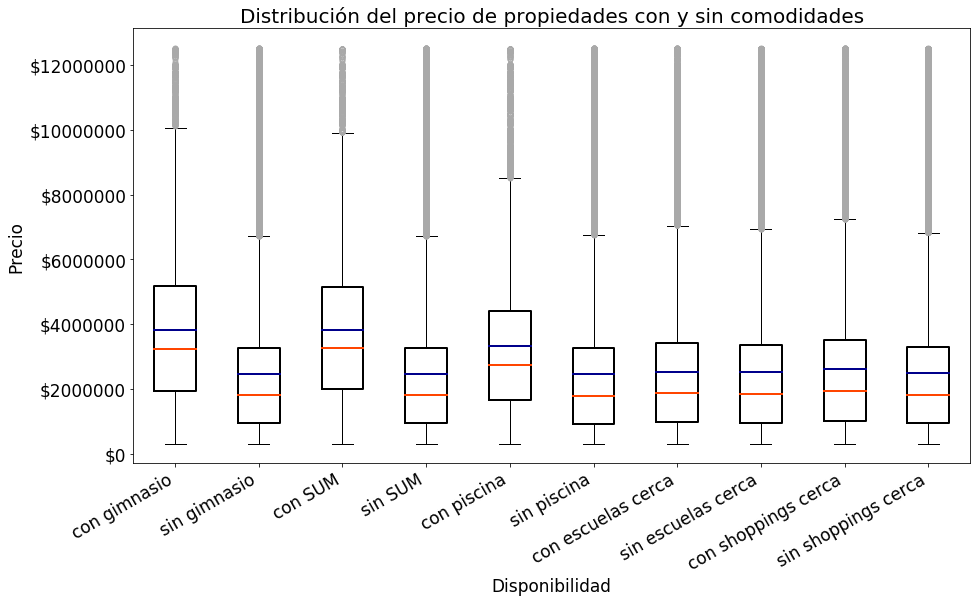

In [15]:
plt.figure(figsize = (15,8))
plt.xticks(fontsize = 17, rotation = 30, ha = 'right')
plt.yticks(fontsize = 17)
plt.title("Distribución del precio de propiedades con y sin comodidades", fontsize = 20)
plot = plt.boxplot([df_abool.loc[df_abool['TieneGimnasio'] == True]['Precio'], \
                    df_abool.loc[df_abool['TieneGimnasio'] == False]['Precio'], \
                    df_abool.loc[df_abool['TieneUsosMultiples'] == True]['Precio'], \
                    df_abool.loc[df_abool['TieneUsosMultiples'] == False]['Precio'], \
                    df_abool.loc[df_abool['TienePileta'] == True]['Precio'], \
                    df_abool.loc[df_abool['TienePileta'] == False]['Precio'], \
                    df_abool.loc[df_abool['TieneEscuelasCerca'] == True]['Precio'], \
                    df_abool.loc[df_abool['TieneEscuelasCerca'] == False]['Precio'], \
                    df_abool.loc[df_abool['TieneShoppingsCerca'] == True]['Precio'], \
                    df_abool.loc[df_abool['TieneShoppingsCerca'] == False]['Precio']], 
                   labels = ['con gimnasio', 'sin gimnasio', \
                             'con SUM', 'sin SUM', \
                             'con piscina', 'sin piscina', \
                             'con escuelas cerca', 'sin escuelas cerca', \
                             'con shoppings cerca', 'sin shoppings cerca'],
                   widths = 0.5, \
                   meanline = True, showmeans=True, \
                   boxprops = dict(linewidth=2), \
                   meanprops = dict(linestyle = '-', linewidth=2, color = 'darkblue'), \
                   # linestyle = '-' muestra la media con línea sólida
                   flierprops = dict(marker='o', markerfacecolor='none', markersize=5, \
                                     linestyle='none', markeredgecolor = 'darkgrey'), \
                   medianprops = dict(linestyle = '-', linewidth=2, color='orangered'))
plt.xlabel('Disponibilidad', fontsize = 17)
plt.ylabel('Precio', fontsize = 17)
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('$%.0f'))
plt.show()

Observando las comodidades propias de las propiedades (gimnasio, Salón de usos múltiples y piscina), se nota que los precios aumentan, lo que es esperable.

La cercanía a comodidades compartidas (escuelas y centros comerciales) no modifica de manera apreciable el valor medio del precio de las propiedades.

In [16]:
# Se cuentan las propiedades con comodidades exclusivas.
solo_gimnasio = len(df_abool.loc[(df_abool['TieneGimnasio'] == True) & \
                                 (df_abool['TieneUsosMultiples'] == False) & \
                                 (df_abool['TienePileta'] == False)])

solo_sum = len(df_abool.loc[(df_abool['TieneGimnasio'] == False) & \
                            (df_abool['TieneUsosMultiples'] == True) & \
                            (df_abool['TienePileta'] == False)])

solo_piscina = len(df_abool.loc[(df_abool['TieneGimnasio'] == False) & \
                                (df_abool['TieneUsosMultiples'] == False) & \
                                (df_abool['TienePileta'] == True)])

print('Solo con gimnasio:', solo_gimnasio, \
      '\nSolo con salón de usos múltiples:', solo_sum, \
      '\nSolo con piscina:', solo_piscina)
proporcion = (solo_gimnasio + solo_sum + solo_piscina)*100/len(dfok)
print('Proporción de estos casos respecto del total:', round(proporcion,2), '%')

Solo con gimnasio: 5614 
Solo con salón de usos múltiples: 4987 
Solo con piscina: 11690
Proporción de estos casos respecto del total: 9.29 %


Como son muy pocos casos se va a tratar la distribuciones de comodidades de manera inclusiva, sin preocupación de si tienen o no otro tipo de amenidad.

In [17]:
# Se referencian los datos para los distintos gráficos.
con_gimnasio = df_abool.loc[df_abool['TieneGimnasio'] == 1]
con_sum = df_abool.loc[df_abool['TieneUsosMultiples'] == 1]
con_piscina = df_abool.loc[df_abool['TienePileta'] == 1]

A continuación se generan DataFrames para tener una lista ordenada con los nombres de las provincias:
1. Se arma un DataFrame agrupando por `Provincia` y realizando una agregación por media de `Precio`;
- Se le cambia el nombre a la columna `{'Precio':'Media Precio'}`;
- Se ordena de mayor a menor por `Media Precio`;
- Se resetea el índice para tener una columna `Provincia` con los nombres de las provincias.


In [18]:
con_gimnasio_orden_media = con_gimnasio.groupby('Provincia').agg({'Precio':'mean'})
con_gimnasio_orden_media.rename(columns = {'Precio' : 'Media Precio'}, inplace=True)
con_gimnasio_orden_media.sort_values(by='Media Precio', ascending = False, inplace = True)
con_gimnasio_orden_media.reset_index(inplace = True)

con_sum_orden_media = con_sum.groupby('Provincia').agg({'Precio':'mean'})
con_sum_orden_media.rename(columns = {'Precio' : 'Media Precio'}, inplace=True)
con_sum_orden_media.sort_values(by='Media Precio', ascending = False, inplace = True)
con_sum_orden_media.reset_index(inplace = True)

con_piscina_orden_media = con_piscina.groupby('Provincia').agg({'Precio':'mean'})
con_piscina_orden_media.rename(columns = {'Precio' : 'Media Precio'}, inplace=True)
con_piscina_orden_media.sort_values(by='Media Precio', ascending = False, inplace = True)
con_piscina_orden_media.reset_index(inplace = True)

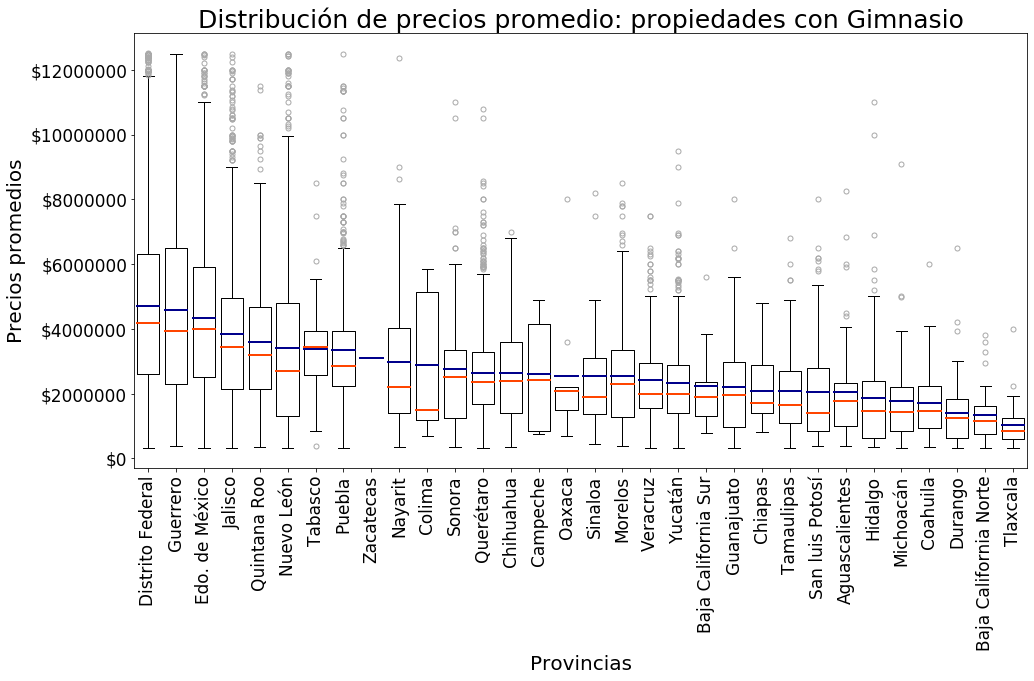

In [19]:
# Gráfico de distribución de precios de propiedades con gimnasio.
plt.figure(figsize = (16,8))
plt.boxplot([
    con_gimnasio.loc[con_gimnasio['Provincia'] == con_gimnasio_orden_media['Provincia'][0]]['Precio'], \
    con_gimnasio.loc[con_gimnasio['Provincia'] == con_gimnasio_orden_media['Provincia'][1]]['Precio'], \
    con_gimnasio.loc[con_gimnasio['Provincia'] == con_gimnasio_orden_media['Provincia'][2]]['Precio'], \
    con_gimnasio.loc[con_gimnasio['Provincia'] == con_gimnasio_orden_media['Provincia'][3]]['Precio'], \
    con_gimnasio.loc[con_gimnasio['Provincia'] == con_gimnasio_orden_media['Provincia'][4]]['Precio'], \
    con_gimnasio.loc[con_gimnasio['Provincia'] == con_gimnasio_orden_media['Provincia'][5]]['Precio'], \
    con_gimnasio.loc[con_gimnasio['Provincia'] == con_gimnasio_orden_media['Provincia'][6]]['Precio'], \
    con_gimnasio.loc[con_gimnasio['Provincia'] == con_gimnasio_orden_media['Provincia'][7]]['Precio'], \
    con_gimnasio.loc[con_gimnasio['Provincia'] == con_gimnasio_orden_media['Provincia'][8]]['Precio'], \
    con_gimnasio.loc[con_gimnasio['Provincia'] == con_gimnasio_orden_media['Provincia'][9]]['Precio'], \
    con_gimnasio.loc[con_gimnasio['Provincia'] == con_gimnasio_orden_media['Provincia'][10]]['Precio'], \
    con_gimnasio.loc[con_gimnasio['Provincia'] == con_gimnasio_orden_media['Provincia'][11]]['Precio'], \
    con_gimnasio.loc[con_gimnasio['Provincia'] == con_gimnasio_orden_media['Provincia'][12]]['Precio'], \
    con_gimnasio.loc[con_gimnasio['Provincia'] == con_gimnasio_orden_media['Provincia'][13]]['Precio'], \
    con_gimnasio.loc[con_gimnasio['Provincia'] == con_gimnasio_orden_media['Provincia'][14]]['Precio'], \
    con_gimnasio.loc[con_gimnasio['Provincia'] == con_gimnasio_orden_media['Provincia'][15]]['Precio'], \
    con_gimnasio.loc[con_gimnasio['Provincia'] == con_gimnasio_orden_media['Provincia'][16]]['Precio'], \
    con_gimnasio.loc[con_gimnasio['Provincia'] == con_gimnasio_orden_media['Provincia'][17]]['Precio'], \
    con_gimnasio.loc[con_gimnasio['Provincia'] == con_gimnasio_orden_media['Provincia'][18]]['Precio'], \
    con_gimnasio.loc[con_gimnasio['Provincia'] == con_gimnasio_orden_media['Provincia'][19]]['Precio'], \
    con_gimnasio.loc[con_gimnasio['Provincia'] == con_gimnasio_orden_media['Provincia'][20]]['Precio'], \
    con_gimnasio.loc[con_gimnasio['Provincia'] == con_gimnasio_orden_media['Provincia'][21]]['Precio'], \
    con_gimnasio.loc[con_gimnasio['Provincia'] == con_gimnasio_orden_media['Provincia'][22]]['Precio'], \
    con_gimnasio.loc[con_gimnasio['Provincia'] == con_gimnasio_orden_media['Provincia'][23]]['Precio'], \
    con_gimnasio.loc[con_gimnasio['Provincia'] == con_gimnasio_orden_media['Provincia'][24]]['Precio'], \
    con_gimnasio.loc[con_gimnasio['Provincia'] == con_gimnasio_orden_media['Provincia'][25]]['Precio'], \
    con_gimnasio.loc[con_gimnasio['Provincia'] == con_gimnasio_orden_media['Provincia'][26]]['Precio'], \
    con_gimnasio.loc[con_gimnasio['Provincia'] == con_gimnasio_orden_media['Provincia'][27]]['Precio'], \
    con_gimnasio.loc[con_gimnasio['Provincia'] == con_gimnasio_orden_media['Provincia'][28]]['Precio'], \
    con_gimnasio.loc[con_gimnasio['Provincia'] == con_gimnasio_orden_media['Provincia'][29]]['Precio'], \
    con_gimnasio.loc[con_gimnasio['Provincia'] == con_gimnasio_orden_media['Provincia'][30]]['Precio'], \
    con_gimnasio.loc[con_gimnasio['Provincia'] == con_gimnasio_orden_media['Provincia'][31]]['Precio']], \
    labels = con_gimnasio_orden_media['Provincia'],             
    widths = 0.8,             
    meanline = True, showmeans = True,             
    boxprops = dict(linewidth=1),             
    meanprops = dict(linestyle = '-', linewidth=2, color = 'darkblue'),             
    # linestyle = '-' muestra la media con línea sólida
    showfliers = True,
    flierprops = dict(marker='o', markerfacecolor='none', markersize=5, linestyle='none', markeredgecolor = 'darkgrey'), \
    medianprops = dict(linestyle = '-', linewidth=2, color='orangered'))
plt.title('Distribución de precios promedio: propiedades con Gimnasio', fontsize = 25)
plt.ylabel('Precios promedios', fontsize = 20)
plt.xlabel('Provincias', fontsize = 20)
plt.xticks(rotation = 90, fontsize = 17)
plt.yticks(fontsize = 17)
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('$%.0f'))
plt.show()

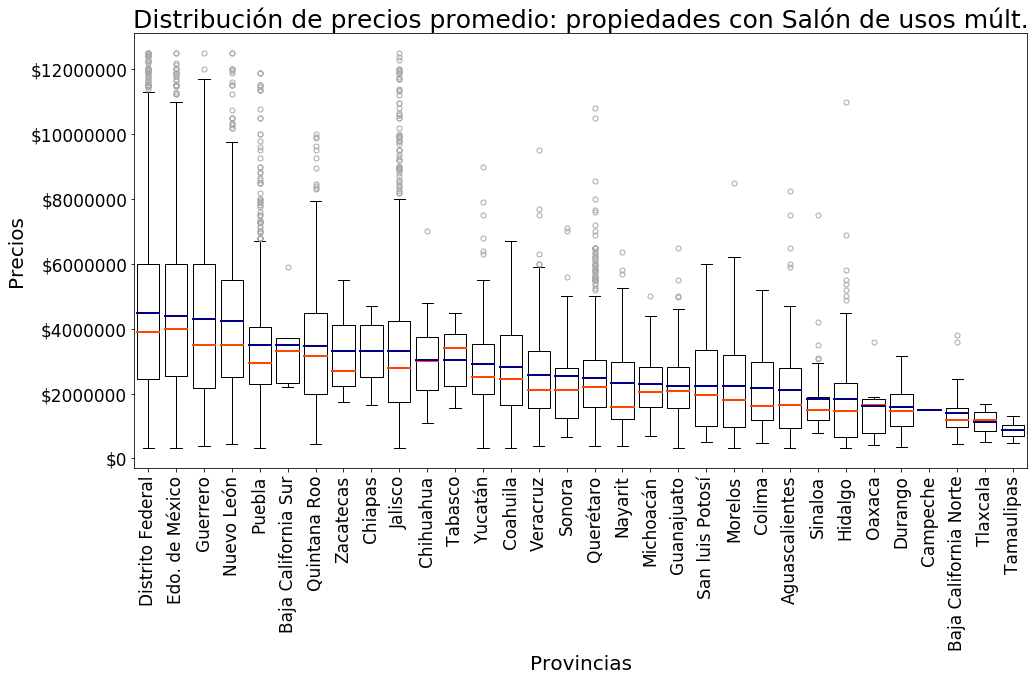

In [20]:
# Gráfico de distribución de precios de propiedades con salón de usos múltiples.
plt.figure(figsize = (16,8))
plt.boxplot([
    con_sum.loc[con_sum['Provincia'] == con_sum_orden_media['Provincia'][0]]['Precio'], \
    con_sum.loc[con_sum['Provincia'] == con_sum_orden_media['Provincia'][1]]['Precio'], \
    con_sum.loc[con_sum['Provincia'] == con_sum_orden_media['Provincia'][2]]['Precio'], \
    con_sum.loc[con_sum['Provincia'] == con_sum_orden_media['Provincia'][3]]['Precio'], \
    con_sum.loc[con_sum['Provincia'] == con_sum_orden_media['Provincia'][4]]['Precio'], \
    con_sum.loc[con_sum['Provincia'] == con_sum_orden_media['Provincia'][5]]['Precio'], \
    con_sum.loc[con_sum['Provincia'] == con_sum_orden_media['Provincia'][6]]['Precio'], \
    con_sum.loc[con_sum['Provincia'] == con_sum_orden_media['Provincia'][7]]['Precio'], \
    con_sum.loc[con_sum['Provincia'] == con_sum_orden_media['Provincia'][8]]['Precio'], \
    con_sum.loc[con_sum['Provincia'] == con_sum_orden_media['Provincia'][9]]['Precio'], \
    con_sum.loc[con_sum['Provincia'] == con_sum_orden_media['Provincia'][10]]['Precio'], \
    con_sum.loc[con_sum['Provincia'] == con_sum_orden_media['Provincia'][11]]['Precio'], \
    con_sum.loc[con_sum['Provincia'] == con_sum_orden_media['Provincia'][12]]['Precio'], \
    con_sum.loc[con_sum['Provincia'] == con_sum_orden_media['Provincia'][13]]['Precio'], \
    con_sum.loc[con_sum['Provincia'] == con_sum_orden_media['Provincia'][14]]['Precio'], \
    con_sum.loc[con_sum['Provincia'] == con_sum_orden_media['Provincia'][15]]['Precio'], \
    con_sum.loc[con_sum['Provincia'] == con_sum_orden_media['Provincia'][16]]['Precio'], \
    con_sum.loc[con_sum['Provincia'] == con_sum_orden_media['Provincia'][17]]['Precio'], \
    con_sum.loc[con_sum['Provincia'] == con_sum_orden_media['Provincia'][18]]['Precio'], \
    con_sum.loc[con_sum['Provincia'] == con_sum_orden_media['Provincia'][19]]['Precio'], \
    con_sum.loc[con_sum['Provincia'] == con_sum_orden_media['Provincia'][20]]['Precio'], \
    con_sum.loc[con_sum['Provincia'] == con_sum_orden_media['Provincia'][21]]['Precio'], \
    con_sum.loc[con_sum['Provincia'] == con_sum_orden_media['Provincia'][22]]['Precio'], \
    con_sum.loc[con_sum['Provincia'] == con_sum_orden_media['Provincia'][23]]['Precio'], \
    con_sum.loc[con_sum['Provincia'] == con_sum_orden_media['Provincia'][24]]['Precio'], \
    con_sum.loc[con_sum['Provincia'] == con_sum_orden_media['Provincia'][25]]['Precio'], \
    con_sum.loc[con_sum['Provincia'] == con_sum_orden_media['Provincia'][26]]['Precio'], \
    con_sum.loc[con_sum['Provincia'] == con_sum_orden_media['Provincia'][27]]['Precio'], \
    con_sum.loc[con_sum['Provincia'] == con_sum_orden_media['Provincia'][28]]['Precio'], \
    con_sum.loc[con_sum['Provincia'] == con_sum_orden_media['Provincia'][29]]['Precio'], \
    con_sum.loc[con_sum['Provincia'] == con_sum_orden_media['Provincia'][30]]['Precio'], \
    con_sum.loc[con_sum['Provincia'] == con_sum_orden_media['Provincia'][31]]['Precio']], \
    labels = con_sum_orden_media['Provincia'],             
    widths = 0.8,             
    meanline = True, showmeans = True,             
    boxprops = dict(linewidth=1),             
    meanprops = dict(linestyle = '-', linewidth=2, color = 'darkblue'),             
    # linestyle = '-' muestra la media con línea sólida
    showfliers = True,
    flierprops = dict(marker='o', markerfacecolor='none', markersize=5, linestyle='none', markeredgecolor = 'darkgrey'), \
    medianprops = dict(linestyle = '-', linewidth=2, color='orangered'))
plt.title('Distribución de precios promedio: propiedades con Salón de usos múlt.', fontsize = 25)
plt.ylabel('Precios', fontsize = 20)
plt.xlabel('Provincias', fontsize = 20)
plt.xticks(rotation = 90, fontsize = 17)
plt.yticks(fontsize = 17)
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('$%.0f'))
plt.show()

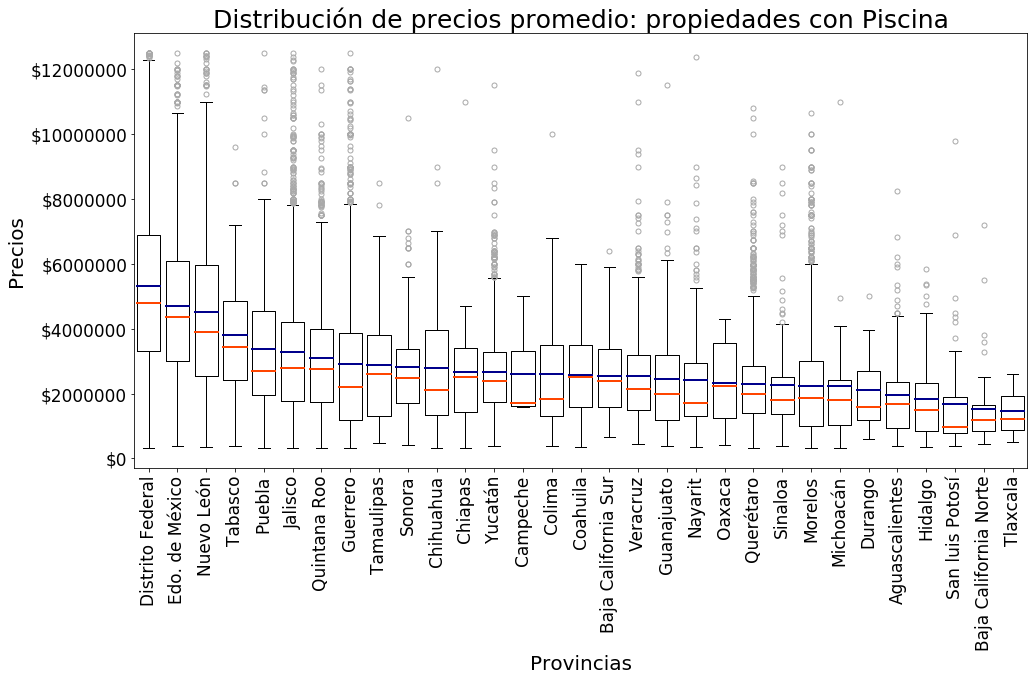

In [21]:
# Gráfico de distribución de precios de propiedades con salón de usos múltiples.
plt.figure(figsize = (16,8))
plt.boxplot([
    con_piscina.loc[con_piscina['Provincia'] == con_piscina_orden_media['Provincia'][0]]['Precio'], \
    con_piscina.loc[con_piscina['Provincia'] == con_piscina_orden_media['Provincia'][1]]['Precio'], \
    con_piscina.loc[con_piscina['Provincia'] == con_piscina_orden_media['Provincia'][2]]['Precio'], \
    con_piscina.loc[con_piscina['Provincia'] == con_piscina_orden_media['Provincia'][3]]['Precio'], \
    con_piscina.loc[con_piscina['Provincia'] == con_piscina_orden_media['Provincia'][4]]['Precio'], \
    con_piscina.loc[con_piscina['Provincia'] == con_piscina_orden_media['Provincia'][5]]['Precio'], \
    con_piscina.loc[con_piscina['Provincia'] == con_piscina_orden_media['Provincia'][6]]['Precio'], \
    con_piscina.loc[con_piscina['Provincia'] == con_piscina_orden_media['Provincia'][7]]['Precio'], \
    con_piscina.loc[con_piscina['Provincia'] == con_piscina_orden_media['Provincia'][8]]['Precio'], \
    con_piscina.loc[con_piscina['Provincia'] == con_piscina_orden_media['Provincia'][9]]['Precio'], \
    con_piscina.loc[con_piscina['Provincia'] == con_piscina_orden_media['Provincia'][10]]['Precio'], \
    con_piscina.loc[con_piscina['Provincia'] == con_piscina_orden_media['Provincia'][11]]['Precio'], \
    con_piscina.loc[con_piscina['Provincia'] == con_piscina_orden_media['Provincia'][12]]['Precio'], \
    con_piscina.loc[con_piscina['Provincia'] == con_piscina_orden_media['Provincia'][13]]['Precio'], \
    con_piscina.loc[con_piscina['Provincia'] == con_piscina_orden_media['Provincia'][14]]['Precio'], \
    con_piscina.loc[con_piscina['Provincia'] == con_piscina_orden_media['Provincia'][15]]['Precio'], \
    con_piscina.loc[con_piscina['Provincia'] == con_piscina_orden_media['Provincia'][16]]['Precio'], \
    con_piscina.loc[con_piscina['Provincia'] == con_piscina_orden_media['Provincia'][17]]['Precio'], \
    con_piscina.loc[con_piscina['Provincia'] == con_piscina_orden_media['Provincia'][18]]['Precio'], \
    con_piscina.loc[con_piscina['Provincia'] == con_piscina_orden_media['Provincia'][19]]['Precio'], \
    con_piscina.loc[con_piscina['Provincia'] == con_piscina_orden_media['Provincia'][20]]['Precio'], \
    con_piscina.loc[con_piscina['Provincia'] == con_piscina_orden_media['Provincia'][21]]['Precio'], \
    con_piscina.loc[con_piscina['Provincia'] == con_piscina_orden_media['Provincia'][22]]['Precio'], \
    con_piscina.loc[con_piscina['Provincia'] == con_piscina_orden_media['Provincia'][23]]['Precio'], \
    con_piscina.loc[con_piscina['Provincia'] == con_piscina_orden_media['Provincia'][24]]['Precio'], \
    con_piscina.loc[con_piscina['Provincia'] == con_piscina_orden_media['Provincia'][25]]['Precio'], \
    con_piscina.loc[con_piscina['Provincia'] == con_piscina_orden_media['Provincia'][26]]['Precio'], \
    con_piscina.loc[con_piscina['Provincia'] == con_piscina_orden_media['Provincia'][27]]['Precio'], \
    con_piscina.loc[con_piscina['Provincia'] == con_piscina_orden_media['Provincia'][28]]['Precio'], \
    con_piscina.loc[con_piscina['Provincia'] == con_piscina_orden_media['Provincia'][29]]['Precio'], \
    con_piscina.loc[con_piscina['Provincia'] == con_piscina_orden_media['Provincia'][30]]['Precio']], \
    labels = con_piscina_orden_media['Provincia'],
    widths = 0.8,             
    meanline = True, showmeans = True,             
    boxprops = dict(linewidth=1),             
    meanprops = dict(linestyle = '-', linewidth=2, color = 'darkblue'),             
    # linestyle = '-' muestra la media con línea sólida
    showfliers = True,
    flierprops = dict(marker='o', markerfacecolor='none', markersize=5, linestyle='none', markeredgecolor = 'darkgrey'),\
    medianprops = dict(linestyle = '-', linewidth=2, color='orangered'))
plt.title('Distribución de precios promedio: propiedades con Piscina', fontsize = 25)
plt.ylabel('Precios', fontsize = 20)
plt.xlabel('Provincias', fontsize = 20)
plt.xticks(rotation = 90, fontsize = 17)
plt.yticks(fontsize = 17)
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('$%.0f'))
plt.show()

Ahora se estudia la distribución de precios por provincia.

In [22]:
# Se crea la lista de provincias ordenadas por media de precios de propiedades.
df_abool_orden_media = df_abool.groupby('Provincia').agg({'Precio':'mean'})
df_abool_orden_media.rename(columns = {'Precio' : 'Media Precio'}, inplace=True)
df_abool_orden_media.sort_values(by='Media Precio', ascending = False, inplace = True)
df_abool_orden_media.reset_index(inplace = True)

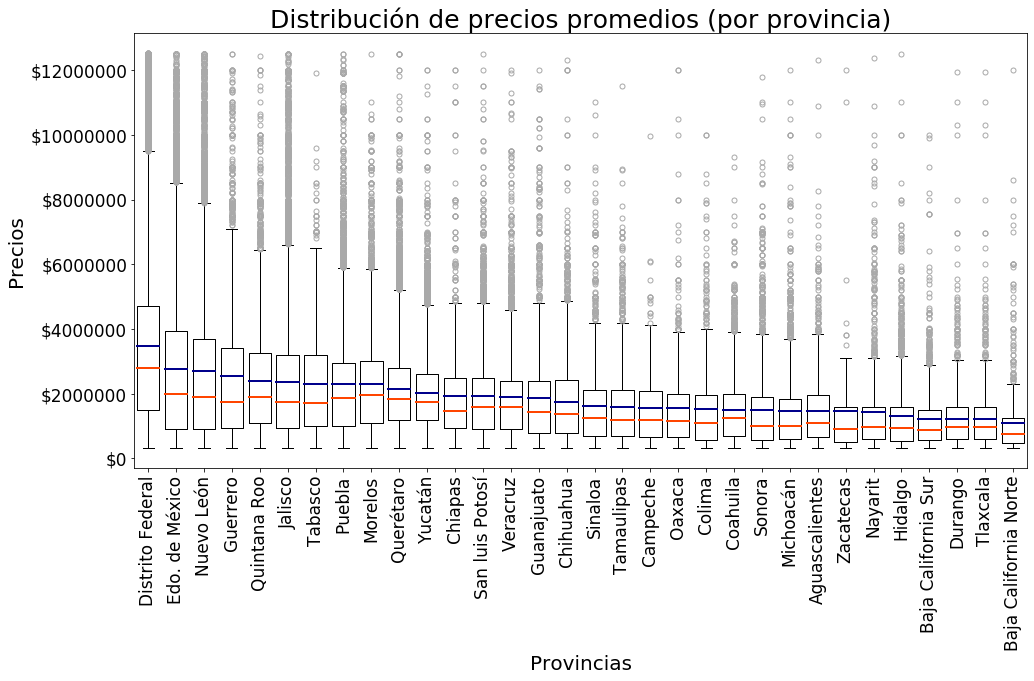

In [23]:
# Gráfico de distribución de precios de propiedades por provincia.
plt.figure(figsize = (16,8))
plt.boxplot([
    df_abool.loc[df_abool['Provincia'] == df_abool_orden_media['Provincia'][0]]['Precio'], \
    df_abool.loc[df_abool['Provincia'] == df_abool_orden_media['Provincia'][1]]['Precio'], \
    df_abool.loc[df_abool['Provincia'] == df_abool_orden_media['Provincia'][2]]['Precio'], \
    df_abool.loc[df_abool['Provincia'] == df_abool_orden_media['Provincia'][3]]['Precio'], \
    df_abool.loc[df_abool['Provincia'] == df_abool_orden_media['Provincia'][4]]['Precio'], \
    df_abool.loc[df_abool['Provincia'] == df_abool_orden_media['Provincia'][5]]['Precio'], \
    df_abool.loc[df_abool['Provincia'] == df_abool_orden_media['Provincia'][6]]['Precio'], \
    df_abool.loc[df_abool['Provincia'] == df_abool_orden_media['Provincia'][7]]['Precio'], \
    df_abool.loc[df_abool['Provincia'] == df_abool_orden_media['Provincia'][8]]['Precio'], \
    df_abool.loc[df_abool['Provincia'] == df_abool_orden_media['Provincia'][9]]['Precio'], \
    df_abool.loc[df_abool['Provincia'] == df_abool_orden_media['Provincia'][10]]['Precio'], \
    df_abool.loc[df_abool['Provincia'] == df_abool_orden_media['Provincia'][11]]['Precio'], \
    df_abool.loc[df_abool['Provincia'] == df_abool_orden_media['Provincia'][12]]['Precio'], \
    df_abool.loc[df_abool['Provincia'] == df_abool_orden_media['Provincia'][13]]['Precio'], \
    df_abool.loc[df_abool['Provincia'] == df_abool_orden_media['Provincia'][14]]['Precio'], \
    df_abool.loc[df_abool['Provincia'] == df_abool_orden_media['Provincia'][15]]['Precio'], \
    df_abool.loc[df_abool['Provincia'] == df_abool_orden_media['Provincia'][16]]['Precio'], \
    df_abool.loc[df_abool['Provincia'] == df_abool_orden_media['Provincia'][17]]['Precio'], \
    df_abool.loc[df_abool['Provincia'] == df_abool_orden_media['Provincia'][18]]['Precio'], \
    df_abool.loc[df_abool['Provincia'] == df_abool_orden_media['Provincia'][19]]['Precio'], \
    df_abool.loc[df_abool['Provincia'] == df_abool_orden_media['Provincia'][20]]['Precio'], \
    df_abool.loc[df_abool['Provincia'] == df_abool_orden_media['Provincia'][21]]['Precio'], \
    df_abool.loc[df_abool['Provincia'] == df_abool_orden_media['Provincia'][22]]['Precio'], \
    df_abool.loc[df_abool['Provincia'] == df_abool_orden_media['Provincia'][23]]['Precio'], \
    df_abool.loc[df_abool['Provincia'] == df_abool_orden_media['Provincia'][24]]['Precio'], \
    df_abool.loc[df_abool['Provincia'] == df_abool_orden_media['Provincia'][25]]['Precio'], \
    df_abool.loc[df_abool['Provincia'] == df_abool_orden_media['Provincia'][26]]['Precio'], \
    df_abool.loc[df_abool['Provincia'] == df_abool_orden_media['Provincia'][27]]['Precio'], \
    df_abool.loc[df_abool['Provincia'] == df_abool_orden_media['Provincia'][28]]['Precio'], \
    df_abool.loc[df_abool['Provincia'] == df_abool_orden_media['Provincia'][29]]['Precio'], \
    df_abool.loc[df_abool['Provincia'] == df_abool_orden_media['Provincia'][29]]['Precio'], \
    df_abool.loc[df_abool['Provincia'] == df_abool_orden_media['Provincia'][30]]['Precio']], \
    labels = df_abool_orden_media['Provincia'],             
    widths = 0.8,             
    meanline = True, showmeans = True,             
    boxprops = dict(linewidth=1),             
    meanprops = dict(linestyle = '-', linewidth=2, color = 'darkblue'),             
    # linestyle = '-' muestra la media con línea sólida
    showfliers = True,
    flierprops = dict(marker='o', markerfacecolor='none', markersize=5, linestyle='none', markeredgecolor = 'darkgrey'), \
    medianprops = dict(linestyle = '-', linewidth=2, color='orangered'))
plt.title('Distribución de precios promedios (por provincia)', fontsize = 25)
plt.ylabel('Precios', fontsize = 20)
plt.xlabel('Provincias', fontsize = 20)
plt.xticks(rotation = 90, fontsize = 17)
plt.yticks(fontsize = 17)
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('$%.0f'))
plt.show()

Todas las medianas están por debajo de las medias.

Luego se busca la provincia que más registro de comodidades tiene, para ver si se comporta de la misma manera.

In [24]:
# Se agrupa por provincias y se suman las comodidades por tipo.
cant_registros_provincia = \
    df_abool\
        .groupby('Provincia')\
        .agg({'TieneGimnasio':'sum', \
              'TieneUsosMultiples':'sum', \
              'TienePileta':'sum', \
              'TieneEscuelasCerca':'sum', \
              'TieneShoppingsCerca':'sum'})
# Se agrega una columna que suma el total de las comodidades por provincia.
cant_registros_provincia['Total'] = cant_registros_provincia.sum(axis = 1)
# Se ordena de forma descendente por total de comodidades por provincia.
cant_registros_provincia.sort_values(by = 'Total', ascending = False, inplace = True)
# Se ubica la provincia con más comodidades registradas.
cant_registros_provincia.iloc[0].to_frame().T

,TieneGimnasio,TieneUsosMultiples,TienePileta,TieneEscuelasCerca,TieneShoppingsCerca,Total
Distrito Federal,4410.0,4044.0,2627.0,28118.0,26185.0,65384.0


In [25]:
# Otra forma de encontrar la provincia con más comodidades (sin ordenar).
cant_registros_provincia\
    .loc[cant_registros_provincia['Total'] == cant_registros_provincia['Total'].max()]

,TieneGimnasio,TieneUsosMultiples,TienePileta,TieneEscuelasCerca,TieneShoppingsCerca,Total
Provincia,,,,,,
Distrito Federal,4410.0,4044.0,2627.0,28118.0,26185.0,65384.0


La provincia con más comodidades anotadas es Distrito Federal.

In [26]:
# Se crea un DataFrame para tener un orden por promedio de precios en ciudades de Distrito Federal.
distrito_federal = df_abool.loc[df_abool['Provincia'] == 'Distrito Federal'].copy()
# Se agrupa por ciudades, se se calcula la media y se ordena de manera descendente.
distrito_federal_ciudades_orden_media = \
    distrito_federal\
        .groupby('Ciudad')\
        .agg({'Precio':'mean'})\
        .sort_values(by = 'Precio', ascending = False)
# Se renombra la columna
distrito_federal_ciudades_orden_media.columns = ['Media Precio']
# Se resetea el índice para tener la columna Ciudad.
distrito_federal_ciudades_orden_media.reset_index(inplace = True)

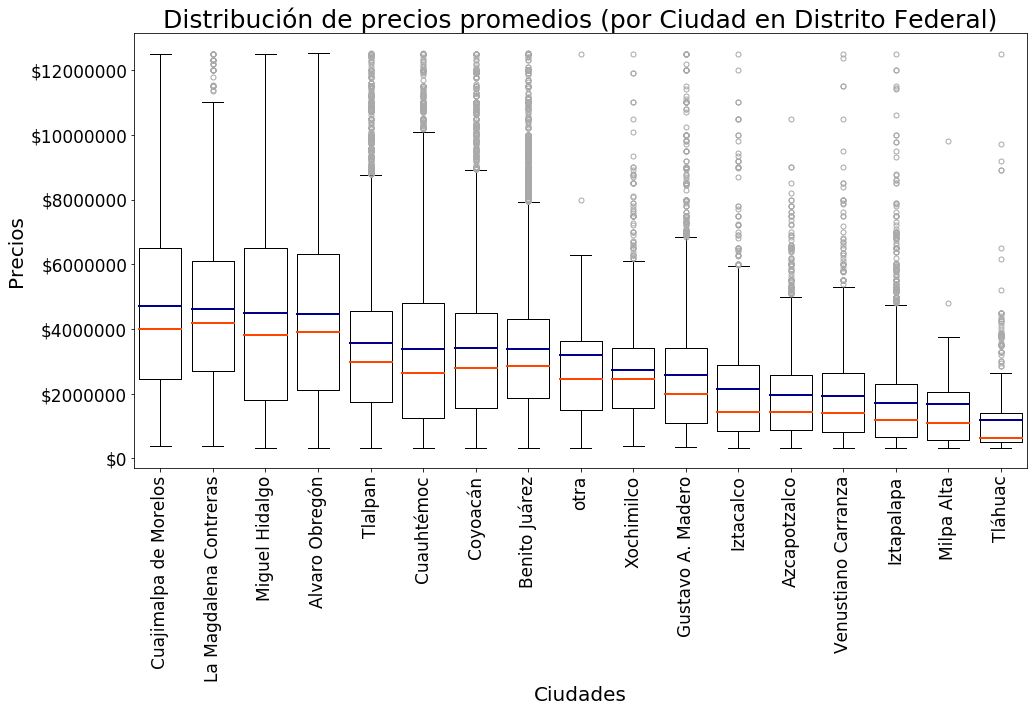

In [27]:
# Gráfico de distribución de precios de propiedades en Distrito Federal, por ciudad.
plt.figure(figsize = (16,8))
plt.boxplot([
    df_abool.loc[df_abool['Ciudad'] == distrito_federal_ciudades_orden_media['Ciudad'][0]]['Precio'], \
    df_abool.loc[df_abool['Ciudad'] == distrito_federal_ciudades_orden_media['Ciudad'][1]]['Precio'], \
    df_abool.loc[df_abool['Ciudad'] == distrito_federal_ciudades_orden_media['Ciudad'][2]]['Precio'], \
    df_abool.loc[df_abool['Ciudad'] == distrito_federal_ciudades_orden_media['Ciudad'][3]]['Precio'], \
    df_abool.loc[df_abool['Ciudad'] == distrito_federal_ciudades_orden_media['Ciudad'][4]]['Precio'], \
    df_abool.loc[df_abool['Ciudad'] == distrito_federal_ciudades_orden_media['Ciudad'][5]]['Precio'], \
    df_abool.loc[df_abool['Ciudad'] == distrito_federal_ciudades_orden_media['Ciudad'][6]]['Precio'], \
    df_abool.loc[df_abool['Ciudad'] == distrito_federal_ciudades_orden_media['Ciudad'][7]]['Precio'], \
    df_abool.loc[df_abool['Ciudad'] == distrito_federal_ciudades_orden_media['Ciudad'][8]]['Precio'], \
    df_abool.loc[df_abool['Ciudad'] == distrito_federal_ciudades_orden_media['Ciudad'][9]]['Precio'], \
    df_abool.loc[df_abool['Ciudad'] == distrito_federal_ciudades_orden_media['Ciudad'][10]]['Precio'], \
    df_abool.loc[df_abool['Ciudad'] == distrito_federal_ciudades_orden_media['Ciudad'][11]]['Precio'], \
    df_abool.loc[df_abool['Ciudad'] == distrito_federal_ciudades_orden_media['Ciudad'][12]]['Precio'], \
    df_abool.loc[df_abool['Ciudad'] == distrito_federal_ciudades_orden_media['Ciudad'][13]]['Precio'], \
    df_abool.loc[df_abool['Ciudad'] == distrito_federal_ciudades_orden_media['Ciudad'][14]]['Precio'], \
    df_abool.loc[df_abool['Ciudad'] == distrito_federal_ciudades_orden_media['Ciudad'][15]]['Precio'], \
    df_abool.loc[df_abool['Ciudad'] == distrito_federal_ciudades_orden_media['Ciudad'][16]]['Precio']], \
    labels = distrito_federal_ciudades_orden_media['Ciudad'],             
    widths = 0.8,             
    meanline = True, showmeans = True,             
    boxprops = dict(linewidth=1),             
    meanprops = dict(linestyle = '-', linewidth=2, color = 'darkblue'),             
    # linestyle = '-' muestra la media con línea sólida
    showfliers = True,
    flierprops = dict(marker='o', markerfacecolor='none', markersize=5, linestyle='none', markeredgecolor = 'darkgrey'), \
    medianprops = dict(linestyle = '-', linewidth=2, color='orangered'))
plt.title('Distribución de precios promedios (por Ciudad en Distrito Federal)', fontsize = 25)
plt.ylabel('Precios', fontsize = 20)
plt.xlabel('Ciudades', fontsize = 20)
plt.xticks(rotation = 90, fontsize = 17)
plt.yticks(fontsize = 17)
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('$%.0f'))
plt.show()

También tiene las medianas por debajo de las medias.

Por otra parte, se puede ver cuáles son las coincidencias para las 10 provincias más caras y las 10 más baratas. Se usa una unión para hallar las mismas.

In [28]:
inicio = 0
fin = 10
coincidencias_caras = pd.merge(df_abool_orden_media[inicio:fin], con_sum_orden_media[inicio:fin], on = ['Provincia'], how = 'inner')
coincidencias_caras = pd.merge(coincidencias_caras, con_piscina_orden_media[inicio:fin], on = ['Provincia'], how = 'inner')
coincidencias_caras = pd.merge(coincidencias_caras, con_gimnasio_orden_media[inicio:fin], on = ['Provincia'], how = 'inner')
coincidencias_caras['Provincia'].to_frame().T

,0,1,2,3,4,5,6
Provincia,Distrito Federal,Edo. de México,Nuevo León,Guerrero,Quintana Roo,Jalisco,Puebla


In [29]:
inicio = 20
fin = 32
coincidencias_baratas = pd.merge(df_abool_orden_media[inicio:fin], con_sum_orden_media[inicio:fin], on = ['Provincia'], how = 'inner')
coincidencias_baratas = pd.merge(coincidencias_baratas, con_piscina_orden_media[inicio:fin], on = ['Provincia'], how = 'inner')
coincidencias_baratas = pd.merge(coincidencias_baratas, con_gimnasio_orden_media[inicio:fin], on = ['Provincia'], how = 'inner')
coincidencias_baratas['Provincia'].to_frame().T

,0,1,2,3,4
Provincia,Aguascalientes,Hidalgo,Durango,Tlaxcala,Baja California Norte


# Análisis de tipo de comodidad a medida que pasan los años

In [30]:
# Se usa df_ok para las columnas porque tiene números en las columnas, sirve para contar.
df_comodidad = dfok[['TieneGimnasio', \
                     'TieneUsosMultiples', \
                     'TienePileta', \
                     'TieneEscuelasCerca', \
                     'TieneShoppingsCerca']]
# Aquí se usa dfok pues tiene la columna 'Antiguedad'
df_comodidad.insert(0, 'Antiguedad', dfok['Antiguedad'])

### Analizo si hay nulos

In [31]:
print(df_comodidad.isnull().sum())
memoria_usada = df_comodidad.memory_usage().sum()/(1024*1024)
print('Memoria usada', memoria_usada.round(2), "MB")

Antiguedad             43555
TieneGimnasio              0
TieneUsosMultiples         0
TienePileta                0
TieneEscuelasCerca         0
TieneShoppingsCerca        0
dtype: int64
Memoria usada 10.99 MB


Hay 43555 casos nulos y es necesario rmoverlos para covertir los tipos. Hasta aquí los tipos del DataFrame df_comodidad son float64.

In [32]:
# Elimino las filas nulas, para así poder realizar las conversión de tipos.
# Además, para este análisis es necesario un valor en la columna 'Antiguedad'.
df_comodidad = df_comodidad.dropna().copy()
df_comodidad.reset_index(drop = True, inplace = True)
df_comodidad.dtypes

Antiguedad             float64
TieneGimnasio          float64
TieneUsosMultiples     float64
TienePileta            float64
TieneEscuelasCerca     float64
TieneShoppingsCerca    float64
dtype: object

In [33]:
# Cambio los tipos del DataFrame
df_comodidad['Antiguedad'] = df_comodidad['Antiguedad'].astype(np.uint8)
df_comodidad['TieneGimnasio'] = df_comodidad['TieneGimnasio'].astype(np.uint8)
df_comodidad['TieneUsosMultiples'] = df_comodidad['TieneUsosMultiples'].astype(np.uint8)
df_comodidad['TienePileta'] = df_comodidad['TienePileta'].astype(np.uint8)
df_comodidad['TieneEscuelasCerca'] = df_comodidad['TieneEscuelasCerca'].astype(np.uint8)
df_comodidad['TieneShoppingsCerca'] = df_comodidad['TieneShoppingsCerca'].astype(np.uint8)
memoria_usada = df_comodidad.memory_usage().sum()/(1024*1024)
print('Memoria usada', memoria_usada.round(2), "MB")

Memoria usada 1.12 MB


Como se tienen 80 años para antigüedad, agregro una columna con rango de años.

In [34]:
# Se define una función de calcula el rango de años dónde cae la antigüedad de la propiedad
# Primero se elige un orden y luego se cambia el nombre de las filas.
# Esto es para evitar tener que insrtar una fila en medio del DataFrame
def rango_de_años(df):
    if df['Antiguedad'] <= 5: return '00'# '0 - 5'
    elif 6  <= df['Antiguedad'] <= 10: return '01'# '6 - 10'
    elif 11 <= df['Antiguedad'] <= 15: return '02'# '11 - 15'
    elif 16 <= df['Antiguedad'] <= 20: return '03'# '16 - 20'
    elif 21 <= df['Antiguedad'] <= 25: return '04'# '21 - 25'
    elif 26 <= df['Antiguedad'] <= 30: return '05'# '26 - 30'
    elif 31 <= df['Antiguedad'] <= 35: return '06'# '31 - 35'
    elif 36 <= df['Antiguedad'] <= 40: return '07'# '26 - 40'
    elif 41 <= df['Antiguedad'] <= 45: return '08'# '41 - 45'
    elif 46 <= df['Antiguedad'] <= 50: return '09'# '46 - 50'
    elif 51 <= df['Antiguedad'] <= 55: return '10'# '51 - 55'
    elif 56 <= df['Antiguedad'] <= 60: return '11'# '56 - 60'
    elif 61 <= df['Antiguedad'] <= 65: return '12'# '61 - 65'
    elif 66 <= df['Antiguedad'] <= 70: return '13'# '66 - 70'
    elif 71 <= df['Antiguedad'] <= 75: return '14'# '71 - 75'
    elif 76 <= df['Antiguedad'] <= 80: return '15'# '76 - 80'

In [35]:
# Auxiliar para asignar rango de años
df_aux = df_comodidad.apply(rango_de_años, axis = 1) # Devuelve una serie

In [36]:
# Se hace una copia para los agrupados
df_comodidad_agrupada5 = df_comodidad.copy()

In [37]:
# Se agrega la columna correspondiente al rango de años de antigüedad
df_comodidad_agrupada5['RangoDeAños'] = df_aux

In [38]:
# Se usa el auxiliar para agrupar por rango de años
df_aux = df_comodidad_agrupada5.groupby('RangoDeAños').agg({'TieneGimnasio':'sum', \
                                        'TieneUsosMultiples':'sum', \
                                        'TienePileta':'sum', \
                                        'TieneEscuelasCerca':'sum', \
                                        'TieneShoppingsCerca':'sum'})
# Aquí df_aux no toma en cuenta la columna Antigüedad

In [39]:
df_comodidad_agrupada5 = df_aux.copy()

In [40]:
# Ahora se cambia el nombre de las filas del índice RangoDeAños
dictionary = {'00':'0 - 5', '01':'6 - 10', '02':'11 - 15', '03':'16 - 20', \
             '04':'21 - 25', '05':'26 - 30', '06':'31 - 35', '07':'36 - 40', \
             '08':'41 - 45', '09':'46 - 50', '10':'51 - 55', '11':'56 - 60', \
             '12':'61 - 65', '13':'66 - 70', '14':'71 - 75', '15':'76 - 80'}
df_comodidad_agrupada5.rename(dictionary, axis=0, inplace=True)

In [41]:
df_comodidad_agrupada5

,TieneGimnasio,TieneUsosMultiples,TienePileta,TieneEscuelasCerca,TieneShoppingsCerca
RangoDeAños,,,,,
0 - 5,10782.0,9652.0,15573.0,58159.0,52386.0
6 - 10,1659.0,1498.0,2236.0,20149.0,18271.0
11 - 15,314.0,218.0,457.0,3610.0,2841.0
16 - 20,544.0,671.0,697.0,12406.0,11514.0
21 - 25,162.0,78.0,138.0,1758.0,1343.0
26 - 30,62.0,85.0,105.0,1834.0,1494.0
31 - 35,15.0,37.0,31.0,652.0,493.0
36 - 40,14.0,19.0,28.0,680.0,527.0
41 - 45,1.0,5.0,4.0,187.0,140.0


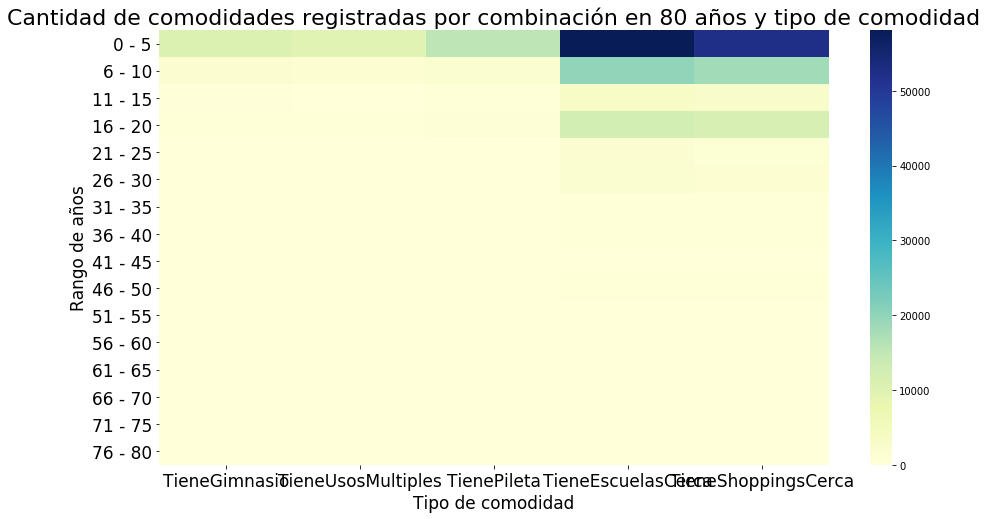

In [42]:
plt.figure(figsize=(15,8))
plot = sb.heatmap(df_comodidad_agrupada5,cmap = 'YlGnBu', cbar = True)
plot.set_title('Cantidad de comodidades registradas por combinación en 80 años y tipo de comodidad', \
               fontsize = 22, y=2)
plot.set_xlabel('Tipo de comodidad', fontsize = 17)
plot.set_ylabel('Rango de años', fontsize = 17)
plt.xticks(fontsize = 17)
plt.yticks(fontsize = 17)
plt.show()

Se ve que en las propiedades antiguas no hay suficiente cantidad de comodidades como para poder apreciarlas en el gráfico

In [43]:
# Si se toman propiedades con hasta 20 años de antigüedad se tiene lo siguiente
df_comodidad_agrupada5[0:4]

,TieneGimnasio,TieneUsosMultiples,TienePileta,TieneEscuelasCerca,TieneShoppingsCerca
RangoDeAños,,,,,
0 - 5,10782.0,9652.0,15573.0,58159.0,52386.0
6 - 10,1659.0,1498.0,2236.0,20149.0,18271.0
11 - 15,314.0,218.0,457.0,3610.0,2841.0
16 - 20,544.0,671.0,697.0,12406.0,11514.0


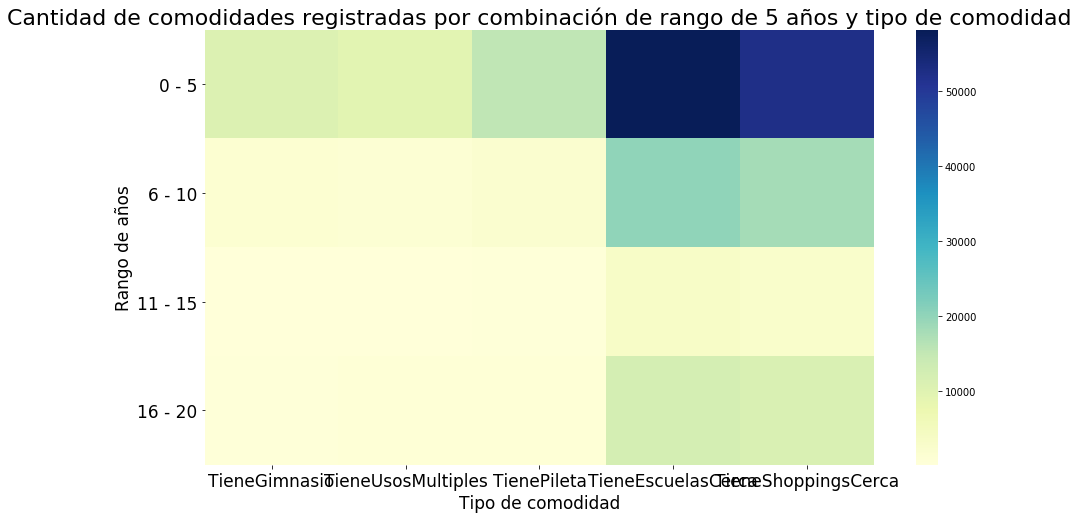

In [44]:
plt.figure(figsize=(15,8))
plot = sb.heatmap(df_comodidad_agrupada5[0:4], cmap = 'YlGnBu', cbar = True, annot = False)
plot.set_title('Cantidad de comodidades registradas por combinación de rango de 5 años y tipo de comodidad', \
               fontsize = 22, y=2)
plot.set_xlabel('Tipo de comodidad', fontsize = 17)
plot.set_ylabel('Rango de años', fontsize = 17)
plt.xticks(fontsize = 17)
plt.yticks(fontsize = 17, rotation = 0)
plt.show()

Se ve que hay una diferencia notoria en la proporción de comodidades compartidas respecto de las propias de las propiedades. Para visualizar puede ser conveniente hacer una distinción.

In [45]:
# Si se descartan las columnas TieneEscuelasCerca y TieneShoppingsCerca se tiene
df_comodidad_agrupada5[['TieneGimnasio', 'TieneUsosMultiples', 'TienePileta']][0:4]

,TieneGimnasio,TieneUsosMultiples,TienePileta
RangoDeAños,,,
0 - 5,10782.0,9652.0,15573.0
6 - 10,1659.0,1498.0,2236.0
11 - 15,314.0,218.0,457.0
16 - 20,544.0,671.0,697.0


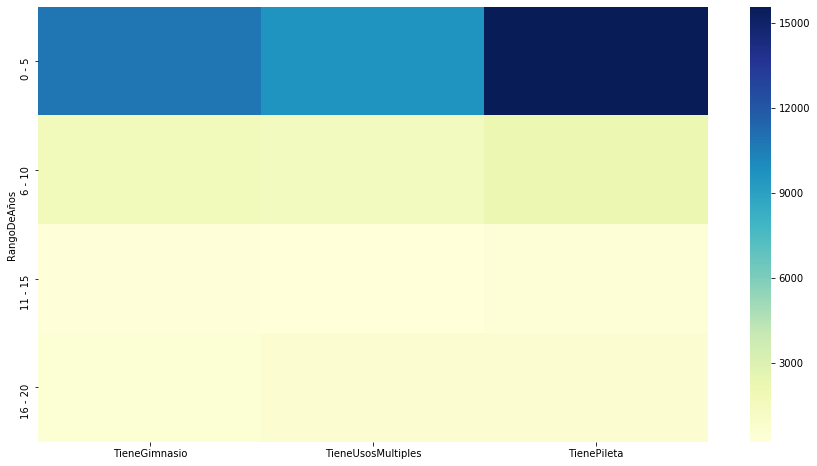

In [46]:
plt.figure(figsize=(15,8))
plot = sb.heatmap(df_comodidad_agrupada5[['TieneGimnasio', 'TieneUsosMultiples', 'TienePileta']][0:4], \
                  cmap = 'YlGnBu', cbar = True)

In [47]:
# Ahora se agrupa por años de antigüedad
df_comodidad_agrupada = df_comodidad\
    .groupby('Antiguedad')\
    .agg({'TieneGimnasio':'sum', \
          'TieneUsosMultiples':'sum', \
          'TienePileta':'sum', \
          'TieneEscuelasCerca':'sum', \
          'TieneShoppingsCerca':'sum'})\
    .copy()

In [48]:
df_comodidad_agrupada.head(10)

,TieneGimnasio,TieneUsosMultiples,TienePileta,TieneEscuelasCerca,TieneShoppingsCerca
Antiguedad,,,,,
0,4400.0,4567.0,6683.0,23777.0,20727.0
1,1311.0,855.0,1974.0,5716.0,4491.0
2,616.0,498.0,904.0,2613.0,2370.0
3,701.0,650.0,1013.0,3068.0,2850.0
4,935.0,818.0,1296.0,4301.0,4056.0
5,2819.0,2264.0,3703.0,18684.0,17892.0
6,280.0,138.0,299.0,1314.0,954.0
7,98.0,102.0,171.0,937.0,790.0
8,85.0,93.0,174.0,1133.0,906.0


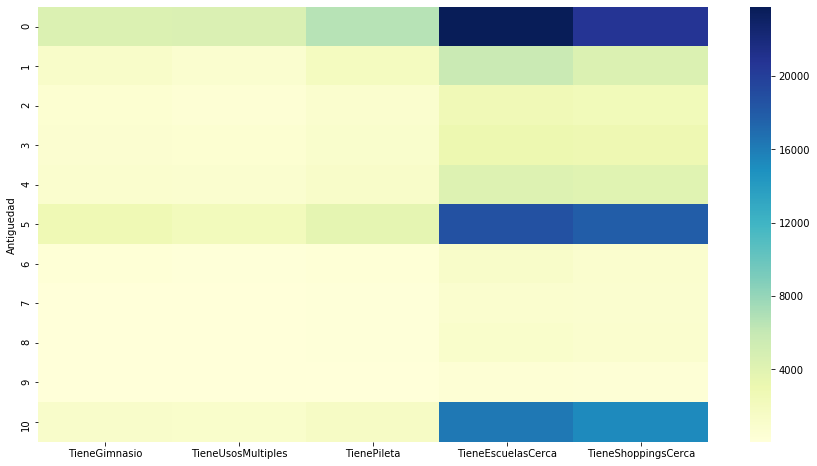

In [49]:
# Se visualiza un heatmap con 10 años de antigüedad
plt.figure(figsize=(15,8))
plot = sb.heatmap(df_comodidad_agrupada[0:11], cmap = 'YlGnBu', cbar = True)

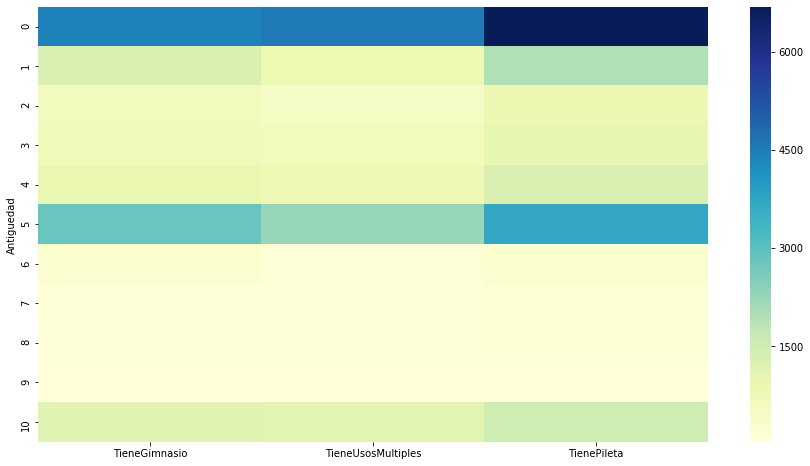

In [50]:
# Se visualiza un heatmap con 10 años de antigüedad
plt.figure(figsize=(15,8))
plot = sb.heatmap(df_comodidad_agrupada[['TieneGimnasio', 'TieneUsosMultiples', 'TienePileta']][0:11], cmap = 'YlGnBu', cbar = True)